In [1]:
import numpy as np
from collections import Counter
from itertools import product
from qiskit import *
from qiskit.algorithms.optimizers import SPSA
import matplotlib.pyplot as plt
import seaborn as sns
from utils import SPSACallback

plt.rcParams["figure.figsize"] = (30,15)
plt.rcParams["font.size"] = 25
RANDOM_STATE = 28
np.random.seed(RANDOM_STATE)

## Generating  random data 

We begin by simualting a gaussian copula. We can use arbitray marginals, but for the sake of simulation they are also assume to 

In [2]:
from generate_data import gaussian_copula,convert_data_to_binary_string,empirical_distribution

P_3 = np.array([[ 1.0, 0.3,  0.2],
              [0.3,  1.0,  0.7],
              [ 0.2,  0.7,  1.0]])

rho = 0.7
mu_c = np.array([0,0])
cov_c = np.array([[1,rho],[rho,1]])

NUM_QUBITS_VAR = 3
NUM_VARS = len(cov_c)
NUM_TRAINING_SAMPLES = 20000

Z, U, G = gaussian_copula(mu_c,cov_c,NUM_TRAINING_SAMPLES)
binary_samples = convert_data_to_binary_string(U,NUM_QUBITS_VAR)
target_probs = empirical_distribution(binary_samples, NUM_QUBITS_VAR*NUM_VARS)

[[2 5]
 [6 4]
 [2 5]
 ...
 [5 5]
 [6 4]
 [4 3]]


In [3]:
bins = np.linspace(0, 1, num=2**3)
inds = np.digitize(U, bins)
print(inds)
bit_data = []
for ind in inds[:2]:
    # Contenate all variables into single bit string
    bit_sample = ""
    for ind_v in ind:
        bit_sample_var = '{:0{size}b}'.format(ind_v, size=3)
        bit_sample += bit_sample_var
    print(bit_sample)
    bit_data.append(bit_sample)

[[2 5]
 [6 4]
 [2 5]
 ...
 [5 5]
 [6 4]
 [4 3]]
010101
110100


In [4]:
print(U[0],bins[inds[0][1]])

[0.14504014 0.59287596] 0.7142857142857142


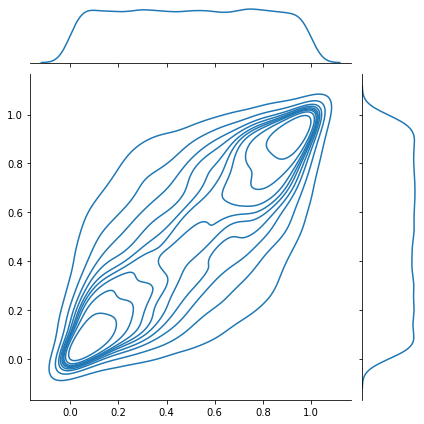

In [5]:
sns.jointplot(x=U[:,1], y=U[:,0], kind="kde");

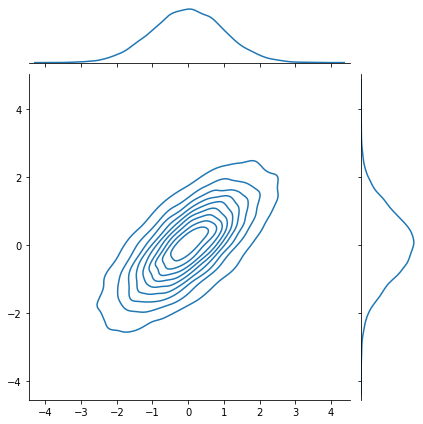

In [6]:
sns.jointplot(x=G[:,1], y=G[:,0], kind="kde");

## Estimate pearson correlation of the U-copula space samples

In [7]:
np.corrcoef(U,rowvar=False)

array([[1.        , 0.68436221],
       [0.68436221, 1.        ]])

In [8]:
NUM_LAYERS = 2
NUM_SHOTS = 2048
NUM_ITERS = 500
spsa_cbk = SPSACallback()
spsa = SPSA(maxiter=NUM_ITERS,callback=spsa_cbk.callback,learning_rate = 0.1,perturbation=0.1)

## Optimizing the QCBM model

In [9]:
from qcbm import QCBM
import time

qcbm_model = QCBM(NUM_QUBITS_VAR,NUM_VARS,NUM_LAYERS,NUM_SHOTS,target_probs)
cost_function = qcbm_model.cost_function
initial_params = 2*np.pi*np.random.rand(3, NUM_QUBITS_VAR*NUM_VARS, NUM_LAYERS).flatten()
start = time.time()
result = spsa.minimize(cost_function, initial_params)
end = time.time()
print("The optimization took : {} secs after {} epochs".format(end-start,NUM_ITERS))

The optimization took : 45.46285676956177 secs after 500 epochs


## Visualizing the loss curve

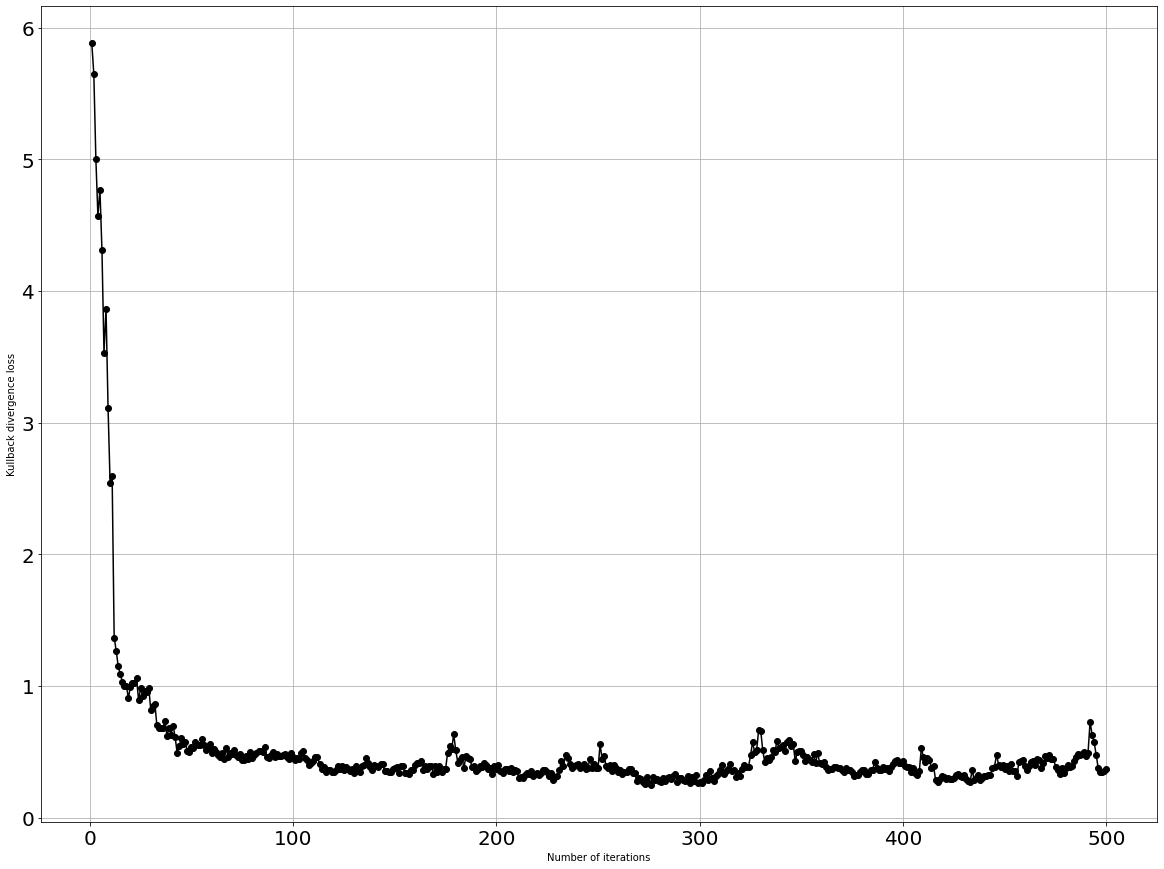

In [10]:
plt.rcParams["figure.figsize"] = (20,15)
plot_data = spsa_cbk.get_callback_data()  # callback data
plt.plot([i + 1 for i in range(len(plot_data[0]))], np.array(plot_data[2]), c="k", marker="o")
plt.xlabel("Number of iterations")
plt.ylabel("Kullback divergence loss")
plt.xticks(size=20)
plt.yticks(size=20)
plt.grid()
plt.show()

## Comparing learned and target distributions

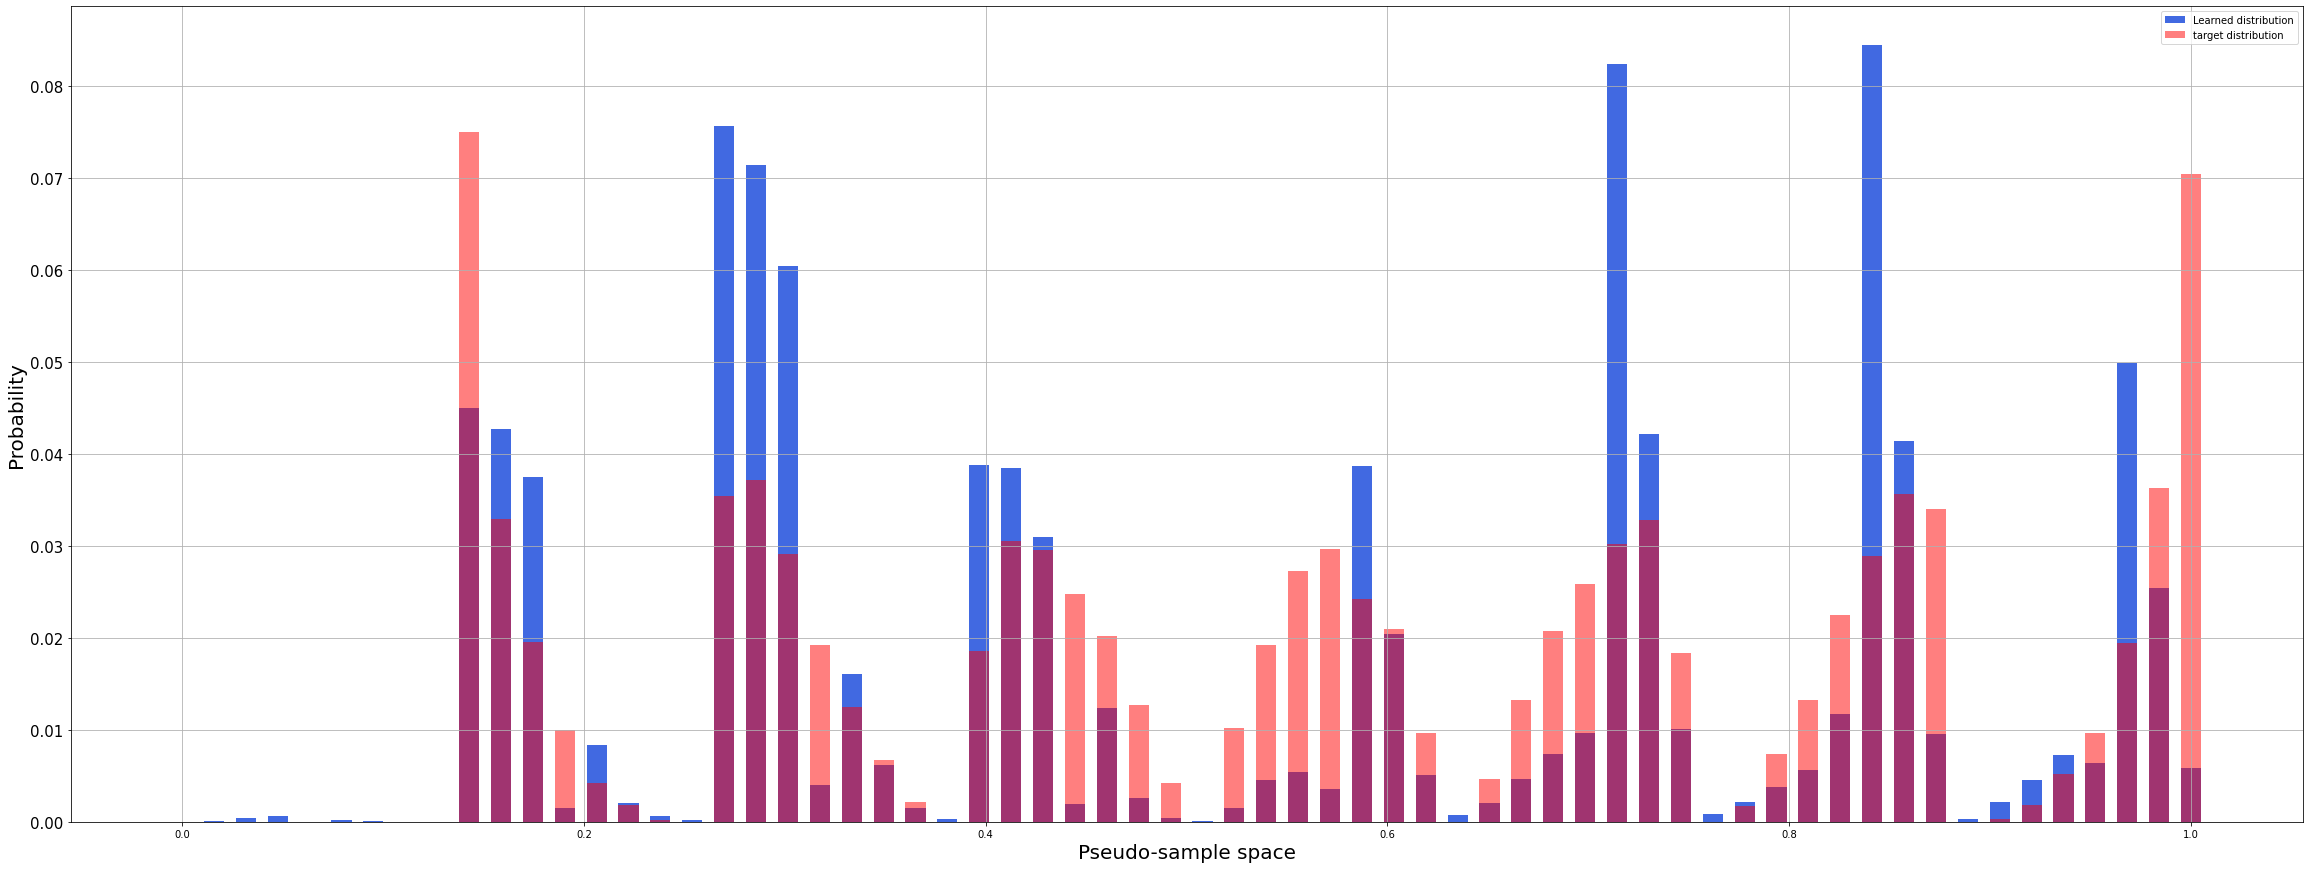

In [11]:
# Evaluate trained probability distribution by comapring histograms 
plt.rcParams["figure.figsize"] = (40,15)
bounds = [0,1]
num_qubits = NUM_QUBITS_VAR*NUM_VARS

x = [bounds[0] + (bounds[1] - bounds[0]) * x / (2**num_qubits - 1) for x in range(2**num_qubits)]

opt_params = result.x
y = qcbm_model.estimate_distribution(opt_params,num_shots= 10000)

# Plot distributions
plt.bar(x, y, width=0.01, label="Learned distribution", color="royalblue")
#plt.xticks(x, size=15, rotation=45)
plt.yticks(size=15)
plt.grid()
plt.xlabel("Pseudo-sample space", size=20)
plt.ylabel("Probability", size=20)
plt.bar(x,target_probs,width=0.01,color="RED",label="target distribution",alpha = 0.5)
plt.legend(loc="best")
plt.show()

In [12]:
print(result)

{   'fun': 0.3541387159530922,
    'jac': None,
    'nfev': 1500,
    'nit': 500,
    'njev': None,
    'x': array([ 0.35469572, -2.92688227,  6.17052983,  3.1865924 ,  2.35086678,
        1.84262796,  6.18387721,  3.97856811,  3.09588446,  1.07278142,
        4.92736144,  3.15946815,  6.70231992,  3.82833858,  6.98881425,
        0.97182575,  5.82722915,  3.66190175,  4.50418684,  2.75909017,
        5.32313945,  2.04533068,  1.40237603,  3.36596916,  3.90368919,
        1.39794638,  0.65177725,  3.19385637,  1.77735119,  3.96932397,
        5.14596833,  4.13947651,  5.60205713,  6.72639657,  1.08393392,
        5.42678404])}


## Sampling from the QCBM after reverse probability integral transform and compare with original random data

In [13]:
import importlib
import qcbm
from qcbm import QCBM
qcbm_model = QCBM(NUM_QUBITS_VAR,NUM_VARS,NUM_LAYERS,NUM_SHOTS,target_probs)
importlib.reload(qcbm)

<module 'qcbm' from '/home/ricardogagu/Escritorio/Quantum Computing/MoodysProblem/Copula-based-QCBM-estimation/qcbm.py'>

In [14]:
from scipy import stats
opt_params = result.x
U_qcbm  = qcbm_model.sample(opt_params,num_shots= 10000)

array([[1.        , 0.64372938],
       [0.64372938, 1.        ]])

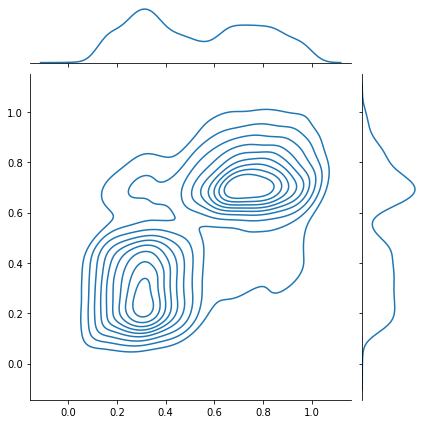

In [15]:
sns.jointplot(x=U_qcbm[:,1], y=U_qcbm[:,0], kind="kde");
np.corrcoef(U_qcbm,rowvar=False)

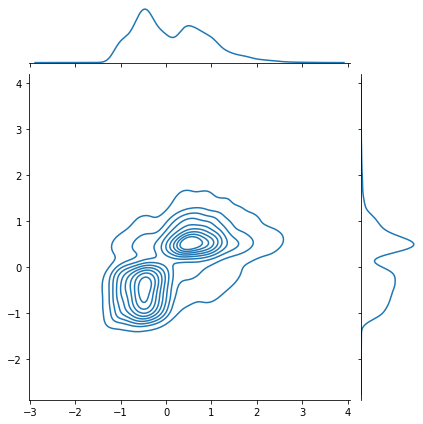

In [16]:
import scipy as sp
G_qcbm = sp.stats.norm.ppf(U_qcbm)
sns.jointplot(x=G_qcbm[:,1], y=G_qcbm[:,0], kind="kde");

In [17]:
np.corrcoef(G_qcbm,rowvar=False)

array([[1.       , 0.5717522],
       [0.5717522, 1.       ]])